# <p style="background-color:#fea162; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">Term Deposit Subscription Prediction in Bank Marketing </p>


## Table of Contents
---

* [Overview](#0)
* [Data Loading and Preparation](#1)
* [Preprocessing Pipelines](#2)
* [Evaluation Helper Function](#3)    
* [Modeling & Tuning Pipelines](#4)
* [Model Comparison](#5)
* [Model Selection & Testing](#6)
* [Feature Importance](#7)
* [Save the Models](#8)
* [Neural Network Classification (Bonus)](#9)
* [Model w/o Call Duration](#10)
* [Conclusion](#11)

<a id="0"></a>

## <p style="background-color:#fea162; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">0. Overview</p>

### 0.1 Background
This project analyzes the Portuguese bank's marketing campaign data to predict whether a client will subscribe to a term deposit. The marketing campaigns involved in this project were based on phone calls. And it is common that more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

By using different ML classification models, we aim to build the most reliable prediction model and identify the most influential factors in predicting a customer's decision of subscribing to a term deposit. Such insights can be used to optimize future marketing outreach and improve the bank's marketing strategy.

### 0.2 Data Source  
The dataset is sourced from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/bank+marketing), containing client profile information,records of direct marketing campaigns (phone calls), and socio-economic indicators from a Portuguese banking institution.

Four datasets were created from the original UCI dataset.

1. `bank-additional-full.csv`: Full dataset with all 41188 records, 20 inputs, ordered by date (from May 2008 to nov 2010). Similar to the data analyzed in [Moro et al., 2014].
2. `bank-additional.csv`: 10% of the examples (4119 records) from `bank-additional-full.csv`. 20 inputs.
3. `bank-full.csv`: Same dataset as 1, but with 17 inputs, ordered by date (it's an older version of the dataset, hence less inputs). Not included in the repo.
4. `bank.csv`: 10% of the examples (4119 records) from `bank-full.csv`. Similarly, 17 inputs. Not included in the repo.

Only 1) and 2) files are included in the repo, and we use only `bank-additional-full.csv` for this analysis.

### 0.3 Column Descriptions  

- Customer Profile
1. age: Age of the client. (numeric)
2. job: Type of job. (categorical)
3. marital: Marital status. (categorical)
4. education: Level of education. (categorical)
5. default: Has credit in default? (categorical)
6. housing: Has a housing loan? (categorical)
7. loan: Has a personal loan? (categorical)

- Contact & Campaign Attributes
8. contact: Communication type. (categorical)
9. month: Last contact month of the year. (categorical)
10. day_of_week: Last contact day of the week. (categorical)
11. duration: Last contact duration in seconds. (numeric)  
   \* *This is a post-hoc variable, not available at the time of before the call. So it's best not to be used for realistic predictive purposes.*
12. campaign: Number of contacts performed during **this** campaign. (numeric)
13. pdays: Days passed since the client was last contacted from a **previous** campaign (999 represents never). (numeric)
14. previous: Number of contacts performed **before this campaign**. (numeric)
15. poutcome: Outcome of the previous marketing campaign. (categorical)

- Socio-Economic Indicators
16. emp_var_rate: Employment variation rate - quarterly indicator. (removed for high correlation)
17. cons_price_idx: Consumer price index - monthly indicator.
18. cons_conf_idx: Consumer confidence index - monthly indicator.
19. euribor3m: Euribor 3 month rate - daily indicator.
20. nr_employed: Number of employees - quarterly indicator. (removed for high correlation)

- Target / Deposit Subscription 
21. y: Has the client subscribed a term deposit? (Target)


### 0.4 Objective
Optimize the predictive model for term deposit subscriptions using a streamlined workflow:
1. Test default performance for each base model.
2. Fine-tune using GridSearchCV/RandomizedSearchCV.
3. Comparing models using AUC-ROC, Macro Avg Recall, and Macro Avg F1 Score.
4. Choose the best model and make final predictions on test set, while optimizing the classifier threshold to maximize F1-score.
5. Inspect feature importances.
6. Deploy the model using Streamlit for interactive predictions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_predict, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support, PrecisionRecallDisplay
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

<a id="1"></a>

## <p style="background-color:#fea162; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">1. Data Loading and Preparation</p>

In [2]:
# Load data
# df = pd.read_csv("data/bank-additional-full.csv", sep=';')
df = pd.read_csv("data/bank-additional-full-cleaned.csv")

# Map target to binary
df.columns = df.columns.str.replace('.','_')
df['y'] = df['y'].map({'yes': 1, 'no': 0})

X = df.drop('y', axis=1)
y = df['y']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape: {X_test.shape}")

Training Shape: (32950, 18)
Testing Shape: (8238, 18)


In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,cons_price_idx,cons_conf_idx,euribor3m,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,93.994,-36.4,4.857,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,93.994,-36.4,4.857,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,93.994,-36.4,4.857,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,93.994,-36.4,4.857,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,93.994,-36.4,4.857,0


In [4]:
df.pdays.value_counts()

pdays
999    39673
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
22         3
19         3
21         2
25         1
26         1
27         1
20         1
Name: count, dtype: int64

In [6]:
# Define column groups
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)

Numeric: ['age', 'duration', 'campaign', 'pdays', 'previous', 'cons_price_idx', 'cons_conf_idx', 'euribor3m']
Categorical: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


In [7]:
# In case of excluding `duration` for realistic prediction, we may use a smaller dataset w/o duration:
new_n_features = [x for x in numeric_features if x != 'duration']

<a id="2"></a>

## <p style="background-color:#fea162; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">2. Preprocessing Pipelines</p>



We differentiate preprocessing for Linear Models vs Tree-based models.
- **LogReg**: StandardScaler + OneHotEncoder(drop='first')
- **Tree Models**: StandardScaler (optional but kept for consistency) + OneHotEncoder(handle_unknown='ignore')

In [8]:
# Preprocessor for Linear/Logistic Models
log_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

log_preprocessor_no_duration = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), new_n_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

# Preprocessor for Tree-based Models
tree_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

tree_preprocessor_no_duration = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), new_n_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

<a id="3"></a>

## <p style="background-color:#fea162; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">3. Evaluation Helper Function</p>
<!-- 
<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#dfa8e4" data-toggle="popover">Content</a> -->


Create a function that retrieves all cross-validation predictions, probabilities, metrics, and aggregated CV prediction (i.e., each val fold's prediction outcome, rather than re-run the model on the entire training set).

In [ ]:
def evaluate_cv(model, X, y, cv=5):
    """
    Performs cross-val predict and returns metrics and report.
    """    
    # y_proba = cross_val_predict(model, X, y, cv=cv, n_jobs=-1, method='predict_proba')[:, 1]
    y_pred = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)

    print("Aggregated Classification Report:\n")
    print(classification_report(y, y_pred))
    print("Aggregated Confusion Matrix:\n", confusion_matrix(y, y_pred))
    
    scoring_metrics = {
        # pos labels
        'f1_pos': 'f1',           
        'recall_pos': 'recall',
        'precision_pos': 'precision',
        # macro
        'f1_macro': 'f1_macro', 
        'balanced_acc': 'balanced_accuracy',
        'roc_auc': 'roc_auc'
    }
    
    metrics = cross_validate(model, X, y, cv=cv, n_jobs=-1, scoring=list(scoring_metrics.values()))

    return y_pred, metrics

## <p style="background-color:#fea162; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">4. Modeling Screening</p>

<a id="4"></a>

We will screening for the following models:

1. Logistic Regression
2. SVC
3. Decision Tree
4. Random Forest
5. XGBoost
6. LightGBM


In [10]:
# Store comparison results
model_results = []

# Weight for class imbalance
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
scale_pos_weight

classifiers = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')),
    ('SVC', SVC(probability=True, random_state=42, class_weight='balanced')),
    ('Decision Tree', DecisionTreeClassifier(random_state=42, class_weight='balanced')),
    ('Random Forest', RandomForestClassifier(random_state=42, class_weight='balanced')),
    ('XGBoost', XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight = scale_pos_weight)),
    ('LightGBM', LGBMClassifier(random_state=42, verbose=-1, importances_type='gain', scale_pos_weight = scale_pos_weight))
]

for model_name, model in classifiers:
    initial_clf = Pipeline([
        ('preprocessor', log_preprocessor if model_name in ['Logistic Regression', 'SVC'] else tree_preprocessor),
        ('classifier', model)
        ])
    print(f"{model_name} performance:\n")
    y_pred, metrics = evaluate_cv(initial_clf, X_train, y_train)
    metrics['Model'] = model_name
    model_results.append(metrics)

Logistic Regression performance:

Aggregated Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.86      0.92     29238
           1       0.44      0.87      0.58      3712

    accuracy                           0.86     32950
   macro avg       0.71      0.87      0.75     32950
weighted avg       0.92      0.86      0.88     32950

Aggregated Confusion Matrix:
 [[25079  4159]
 [  465  3247]]
SVC performance:

Aggregated Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.84      0.91     29238
           1       0.42      0.91      0.58      3712

    accuracy                           0.85     32950
   macro avg       0.70      0.88      0.74     32950
weighted avg       0.92      0.85      0.87     32950

Aggregated Confusion Matrix:
 [[24574  4664]
 [  319  3393]]
Decision Tree performance:

Aggregated Classification Report:

              precision    recall  f1-s

/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted w

Aggregated Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.87      0.92     29238
           1       0.46      0.90      0.61      3712

    accuracy                           0.87     32950
   macro avg       0.72      0.89      0.77     32950
weighted avg       0.93      0.87      0.89     32950

Aggregated Confusion Matrix:
 [[25342  3896]
 [  356  3356]]


/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted w

In [11]:
model_results

[{'fit_time': array([0.07664514, 0.09096503, 0.0983789 , 0.07930613, 0.08420515]),
  'score_time': array([0.02102613, 0.0349021 , 0.0236938 , 0.02602792, 0.02311087]),
  'test_f1': array([0.58802178, 0.58796718, 0.57244129, 0.58488004, 0.58740018]),
  'test_recall': array([0.87331536, 0.86927224, 0.87061995, 0.86944818, 0.8909825 ]),
  'test_precision': array([0.44322845, 0.44421488, 0.42640264, 0.44065484, 0.43812045]),
  'test_f1_macro': array([0.75264792, 0.75284032, 0.7420478 , 0.75064802, 0.75114106]),
  'test_balanced_accuracy': array([0.86706124, 0.86563817, 0.86101107, 0.86460266, 0.87288992]),
  'test_roc_auc': array([0.93245208, 0.9349848 , 0.92797777, 0.93370518, 0.93788926]),
  'Model': 'Logistic Regression'},
 {'fit_time': array([90.25178909, 91.11660075, 88.95714092, 91.23530197, 92.69248819]),
  'score_time': array([4.10335279, 3.92422915, 4.3514719 , 4.1338172 , 3.8006568 ]),
  'test_f1': array([0.56971257, 0.59781182, 0.56757895, 0.58021053, 0.5684561 ]),
  'test_recal

In [12]:
final_results = []
for metrics in model_results:
    avg_metrics = {}
    
    for key, value in metrics.items():
        if key == 'Model':
            # Keep the model name as is
            avg_metrics[key] = value
        else:
            # Calculate the mean of the 5 folds
            avg_metrics[key] = np.mean(value)
            
    final_results.append(avg_metrics)

df_metrics = pd.DataFrame(final_results)

cols = ['Model'] + [c for c in df_metrics.columns if c != 'Model']
df_metrics = df_metrics[cols]

In [14]:
df_metrics.sort_values(by='test_f1_macro', ascending=False)

,Model,fit_time,score_time,test_f1,test_recall,test_precision,test_f1_macro,test_balanced_accuracy,test_roc_auc
4,XGBoost,0.303637,0.037195,0.619198,0.828115,0.494672,0.775819,0.860309,0.939972
5,LightGBM,2.130837,0.050552,0.612378,0.904090,0.463129,0.767482,0.885419,0.947470
0,Logistic Regression,0.085900,0.025752,0.584142,0.874728,0.438524,0.749865,0.866241,0.933402
1,SVC,90.850664,4.062706,0.576754,0.914058,0.421376,0.742342,0.877269,0.932893
2,Decision Tree,0.160737,0.023289,0.490721,0.474136,0.508863,0.714258,0.707979,0.707979
3,Random Forest,1.517646,0.138695,0.478448,0.377155,0.654369,0.713811,0.675923,0.938508


                 Model   fit_time  score_time   test_f1  test_recall  \
4              XGBoost   0.303637    0.037195  0.619198     0.828115   
5             LightGBM   2.130837    0.050552  0.612378     0.904090   
0  Logistic Regression   0.085900    0.025752  0.584142     0.874728   
1                  SVC  90.850664    4.062706  0.576754     0.914058   
2        Decision Tree   0.160737    0.023289  0.490721     0.474136   
3        Random Forest   1.517646    0.138695  0.478448     0.377155   

   test_precision  test_f1_macro  test_balanced_accuracy  test_roc_auc  
4        0.494672       0.775819                0.860309      0.939972  
5        0.463129       0.767482                0.885419      0.947470  
0        0.438524       0.749865                0.866241      0.933402  
1        0.421376       0.742342                0.877269      0.932893  
2        0.508863       0.714258                0.707979      0.707979  
3        0.654369       0.713811                0.675923 

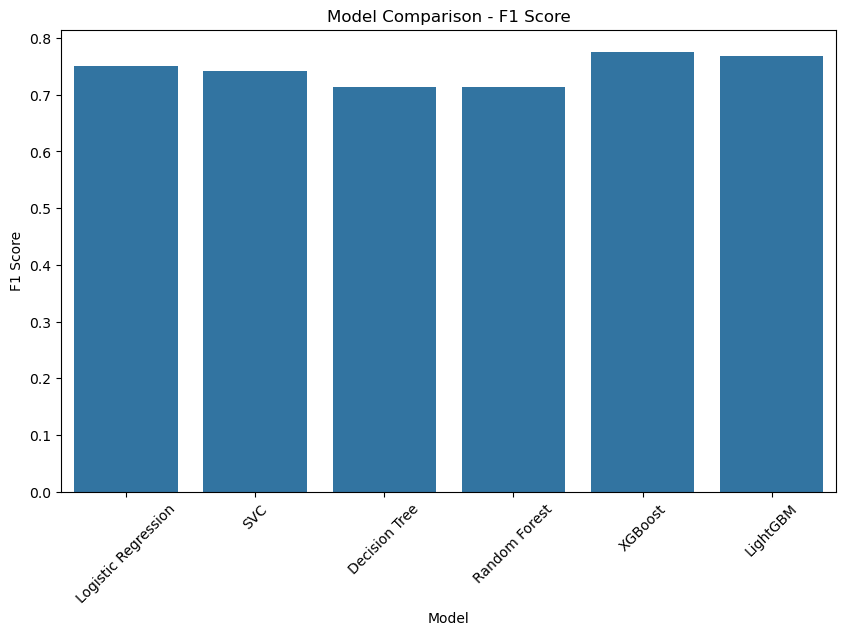

In [15]:
print(df_metrics.sort_values(by='test_f1_macro', ascending=False))

plt.figure(figsize=(10, 6))
sns.barplot(x=df_metrics['Model'], y=df_metrics['test_f1_macro'])
plt.title('Model Comparison - F1 Score')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.show()

<a id="5"></a>
## <p style="background-color:#fea162; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">5. Model Finetuning</p>

### 5.1 XGBoost

In [16]:
xgb_clf = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('classifier', XGBClassifier(eval_metric='logloss', random_state=42))
])

# Tuning:
print("\nTuning XGBoost...")
param_xgb = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__scale_pos_weight': [scale_pos_weight, 10, None]
}
rand_xgb = GridSearchCV(xgb_clf, param_grid=param_xgb, cv=5, scoring='f1', n_jobs=-1, verbose = 2)
rand_xgb.fit(X_train, y_train)

print(f"Best Params: {rand_xgb.best_params_}")
best_xgb_clf = rand_xgb.best_estimator_

# Best Model Eval
y_pred, metrics_xgb = evaluate_cv(best_xgb_clf, X_train, y_train)
metrics_xgb['Model'] = 'XGBoost'


Tuning XGBoost...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__scale_pos_weight=7.876616379310345, classifier__subsample=0.8; total time=   0.5s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__scale_pos_weight=7.876616379310345, classifier__subsample=0.8; total time=   0.5s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__scale_pos_weight=7.876616379310345, classifier__subsample=1.0; total time=   0.4s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__scale_pos_weight=7.876616379310345, classifier__subsample=0.8; total time=   0.5s
[CV] END classifier__

In [17]:
rand_xgb.best_params_

{'classifier__colsample_bytree': 1.0,
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 7,
 'classifier__n_estimators': 200,
 'classifier__scale_pos_weight': 7.876616379310345,
 'classifier__subsample': 0.8}

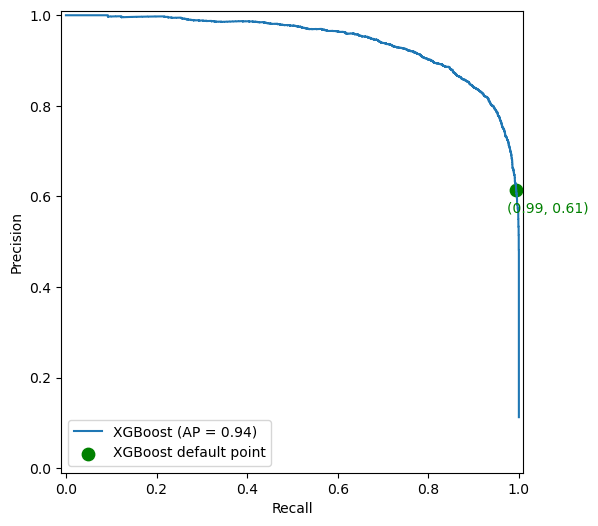

In [107]:
# Plot PR curve

# PR curve points (this is for label = 1; if checking label = 0, use predict_proba[:,0] & pos_label=0)
precision, recall, thresholds = precision_recall_curve(y_train, best_xgb_clf.predict_proba(X_train)[:,1])

# # default point's prec and rec
prec, rec, f1, _ = precision_recall_fscore_support(y_train, best_xgb_clf.predict(X_train), average="binary")

fig, ax = plt.subplots(figsize=(8, 6))
disp2 = PrecisionRecallDisplay.from_estimator(best_xgb_clf, X_train, y_train, ax=ax, name="XGBoost")

ax.scatter(rec, prec, color="green", s=80, label="XGBoost default point")
ax.text(rec - 0.02, prec - 0.05, f"({rec:.2f}, {prec:.2f})", color="green")

ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
plt.show()


In [19]:
# define a function to search the best threshold
def search_best_threshold(precision, recall, thresholds):
    f1 = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-12)
    best_idx = np.argmax(f1)
    best_threshold = thresholds[best_idx]
    best_precision = precision[best_idx]
    best_recall = recall[best_idx]
    return best_threshold, f1


0.77604586


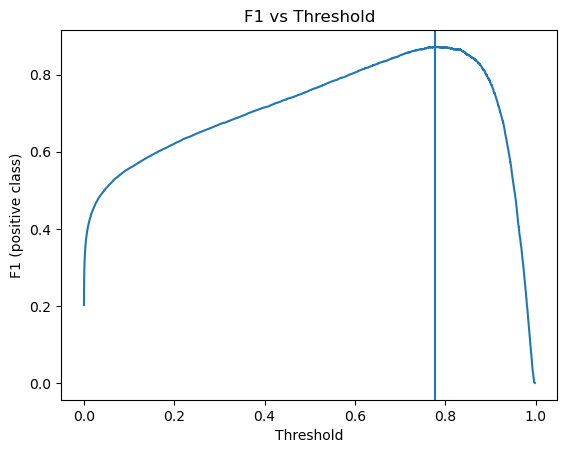

In [108]:
# Find best threshold for training set, xgb
best_t_xgb, f1_xgb = search_best_threshold(precision, recall, thresholds)  
print(best_t_xgb)

plt.plot(thresholds, f1_xgb)
plt.axvline(best_t_xgb)
plt.xlabel("Threshold")
plt.ylabel("F1 (positive class)")
plt.title("F1 vs Threshold")
plt.show()

0.77604586


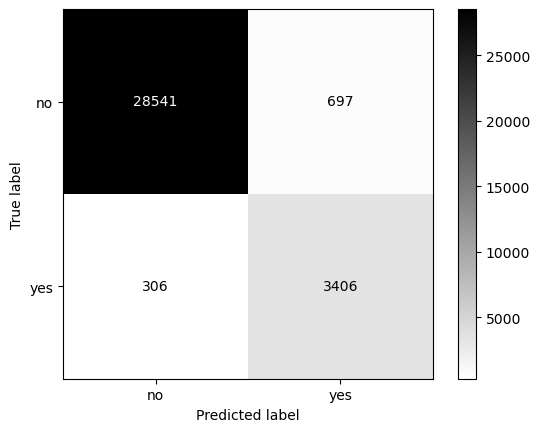

In [109]:
# Post-adjustment Confusion Matrix (only use predict_proba because cross_eval's predict is a concatenated array of five cv models)
print(best_t_xgb)

post_disp = ConfusionMatrixDisplay.from_predictions(y_train, (best_xgb_clf.predict_proba(X_train)[:,1]>=best_t_xgb).astype(int), display_labels = ['no', 'yes'], cmap = 'gray_r')
# post_disp = ConfusionMatrixDisplay.from_predictions(y_train, (y_proba>=best_t).astype(int), display_labels = ['no', 'yes'], cmap = 'gray_r')

post_disp.ax_.grid(False)

In [22]:
rand_xgb.best_params_

{'classifier__colsample_bytree': 1.0,
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 7,
 'classifier__n_estimators': 200,
 'classifier__scale_pos_weight': 7.876616379310345,
 'classifier__subsample': 0.8}

In [23]:
metrics_xgb['test_f1_macro'].mean(), metrics_xgb['test_f1'].mean()

(np.float64(0.7817703011424988), np.float64(0.6276282903980732))

### 5.2 LightGBM

In [24]:
lgbm_clf = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('classifier', LGBMClassifier(random_state=42, verbose=-1, importances_type='gain'))
])

# Tuning - using RandomizedSearchCV
print("\nTuning LightGBM...")
param_dist_lgbm = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__num_leaves': [31, 50, 100],
    'classifier__max_depth': [-1, 10, 20],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__class_weight': ['balanced', None]
}
rand_lgbm = RandomizedSearchCV(lgbm_clf, param_distributions=param_dist_lgbm, n_iter=20, cv=5, scoring='f1', n_jobs=-1, random_state=42)
rand_lgbm.fit(X_train, y_train)

print(f"Best Params: {rand_lgbm.best_params_}")
best_lgbm_clf = rand_lgbm.best_estimator_

# Best Model Eval
y_pred,metrics_lgbm = evaluate_cv(best_lgbm_clf, X_train, y_train)
metrics_lgbm['Model'] = 'LightGBM'


Tuning LightGBM...


/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted w

Best Params: {'classifier__subsample': 1.0, 'classifier__num_leaves': 50, 'classifier__n_estimators': 500, 'classifier__max_depth': -1, 'classifier__learning_rate': 0.05, 'classifier__colsample_bytree': 0.8, 'classifier__class_weight': 'balanced'}


/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted w

Aggregated Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.90      0.94     29238
           1       0.51      0.84      0.64      3712

    accuracy                           0.89     32950
   macro avg       0.74      0.87      0.79     32950
weighted avg       0.93      0.89      0.90     32950

Aggregated Confusion Matrix:
 [[26278  2960]
 [  605  3107]]


/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted w

In [25]:
metrics_lgbm['test_f1_macro'].mean(), metrics_lgbm['test_f1'].mean()

(np.float64(0.7860155806976646), np.float64(0.6355622690773238))

0.8010018328012126


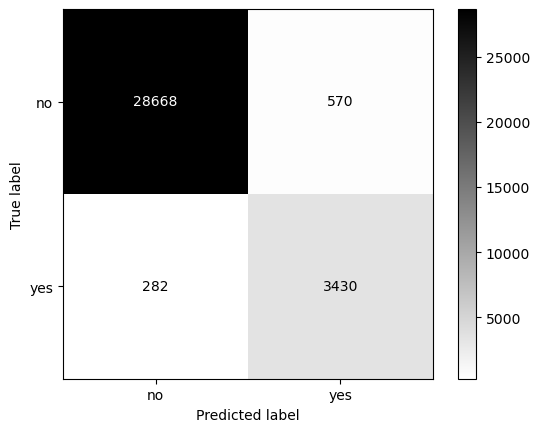

In [110]:
# search the best threshold
precision, recall, thresholds = precision_recall_curve(y_train, best_lgbm_clf.predict_proba(X_train)[:,1])

best_t_lgbm, f1_lgbm = search_best_threshold(precision, recall, thresholds)

disp = ConfusionMatrixDisplay.from_predictions(y_train, (best_lgbm_clf.predict_proba(X_train)[:,1] >= best_t_lgbm).astype(int), display_labels = ['no', 'yes'], cmap = 'gray_r')
disp.ax_.grid(False)

print(best_t_lgbm)

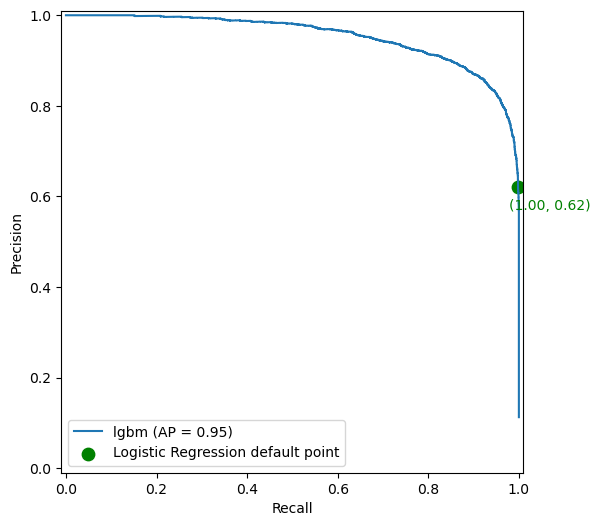

In [111]:
fig, ax = plt.subplots(figsize=(8, 6))

disp2 = PrecisionRecallDisplay.from_estimator(best_lgbm_clf, X_train, y_train, ax=ax, name="lgbm")
prec, rec, f1_scores, _ = precision_recall_fscore_support(y_train, best_lgbm_clf.predict(X_train), average="binary")

ax.scatter(rec, prec, color="green", s=80, label="Logistic Regression default point")
ax.text(rec - 0.02, prec - 0.05, f"({rec:.2f}, {prec:.2f})", color="green")

ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
plt.show()

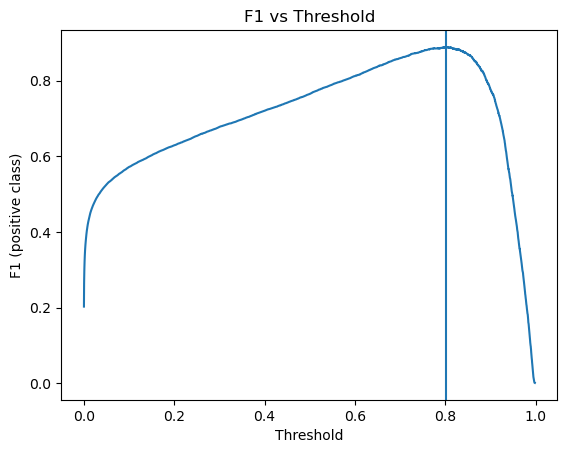

In [112]:
plt.plot(thresholds, f1_lgbm)
plt.axvline(best_t_lgbm)
plt.xlabel("Threshold")
plt.ylabel("F1 (positive class)")
plt.title("F1 vs Threshold")
plt.show()

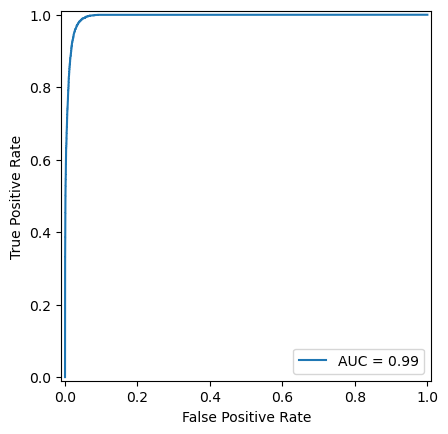

In [113]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

fpr, tpr, ts = roc_curve(y_train, best_lgbm_clf.predict_proba(X_train)[:, 1])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()

## <p style="background-color:#fea162; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">6. Model Selection & Testing</p>

<a id="6"></a>



We select the model with the best cross-validation F1 score - LightGBM (slightly better) as the final model.

In [114]:
best_model_name = 'LightGBM'
final_model = best_lgbm_clf
# Predict on Test Set
y_test_pred = final_model.predict(X_test)
y_test_proba = final_model.predict_proba(X_test)[:, 1]

print("--- Final Test Set Evaluation ---")
print(classification_report(y_test, (y_test_proba>=0.5).astype(int)))
print("Confusion Matrix:\n", confusion_matrix(y_test, (y_test_proba>=0.5).astype(int)))
print(f"Accuracy: {accuracy_score(y_test, (y_test_proba>=0.5).astype(int)):.4f}")

--- Final Test Set Evaluation ---
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      7310
           1       0.52      0.86      0.65       928

    accuracy                           0.90      8238
   macro avg       0.75      0.88      0.80      8238
weighted avg       0.93      0.90      0.91      8238

Confusion Matrix:
 [[6581  729]
 [ 128  800]]
Accuracy: 0.8960


In [ ]:
# Adating training set's threshold
best_t_lgbm
# precision, recall, thresholds = precision_recall_curve(y_test, best_lgbm_clf.predict_proba(X_test)[:,1])
# best_t_test, f1 = search_best_threshold(precision, recall, thresholds)

# best_t_test

np.float64(0.6446650579336785)

In [121]:
print("--- Final Test Set Evaluation ---")
print(classification_report(y_test, (y_test_proba>=best_t_lgbm).astype(int)))
print("Confusion Matrix:\n", confusion_matrix(y_test, (y_test_proba>=best_t_lgbm).astype(int)))
print(f"Accuracy: {accuracy_score(y_test, (y_test_proba>=best_t_lgbm).astype(int)):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")

--- Final Test Set Evaluation ---
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7310
           1       0.64      0.64      0.64       928

    accuracy                           0.92      8238
   macro avg       0.80      0.80      0.80      8238
weighted avg       0.92      0.92      0.92      8238

Confusion Matrix:
 [[6977  333]
 [ 337  591]]
Accuracy: 0.9187
AUC-ROC: 0.9524


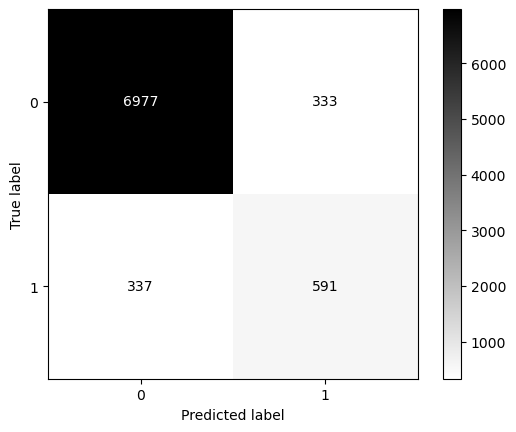

In [123]:
fin_disp = ConfusionMatrixDisplay.from_predictions(y_test, y_test_proba >= best_t_lgbm, cmap = 'gray_r')
fin_disp.ax_.grid(False)

### Considerations for SMOTE:

In [42]:
# Apply SMOTE to training data only
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
X_train_encoded = X_train.copy()
X_train_encoded[categorical_features] = encoder.fit_transform(X_train[categorical_features])


In [43]:
cat_indices = [X_train_encoded.columns.get_loc(col) for col in categorical_features]

smote_nc = SMOTENC(
    categorical_features=cat_indices,
    random_state=42
)

X_res, y_res = smote_nc.fit_resample(X_train_encoded, y_train)

In [44]:
y_res.value_counts()

y
0    29238
1    29238
Name: count, dtype: int64

In [45]:
# the boosting models don't benefit from SMOTE (XGB even gets worse)

new_m = rand_lgbm.best_estimator_
new_m.fit(X_train, y_train)

confusion_matrix(y_test, new_m.predict(X_test))

array([[6581,  729],
       [ 128,  800]])

In [46]:
from sklearn.base import clone

# Train RF on oversampled data - solid improvement, but not so much. Precision still low.
new_rf = Pipeline([
        ('preprocessor', tree_preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
])
new_rf.fit(X_res, y_res)

confusion_matrix(y_test, new_rf.predict(X_test))


array([[6894,  416],
       [ 401,  527]])

In [47]:
# Train Logistic Regression on oversampled data - some improvement, but adjusting threshold makes it worse.
new_log_clf = Pipeline([
        ('preprocessor', log_preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])
new_log_clf.fit(X_res, y_res)

confusion_matrix(y_test, new_log_clf.predict(X_test))


array([[6815,  495],
       [ 314,  614]])

In [122]:
precision, recall, thresholds = precision_recall_curve(y_res, new_log_clf.predict_proba(X_res)[:, 1])
best_t_log, _ = search_best_threshold(precision, recall, thresholds)

print(f'best_threshold: {best_t_log}')
confusion_matrix(y_test, (new_log_clf.predict_proba(X_test)[:, 1] >= best_t_log).astype(int))

best_threshold: 0.4136004954229586


array([[6679,  631],
       [ 239,  689]])

## <p style="background-color:#fea162; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">7. Feature Importance</p>

<a id="7"></a>

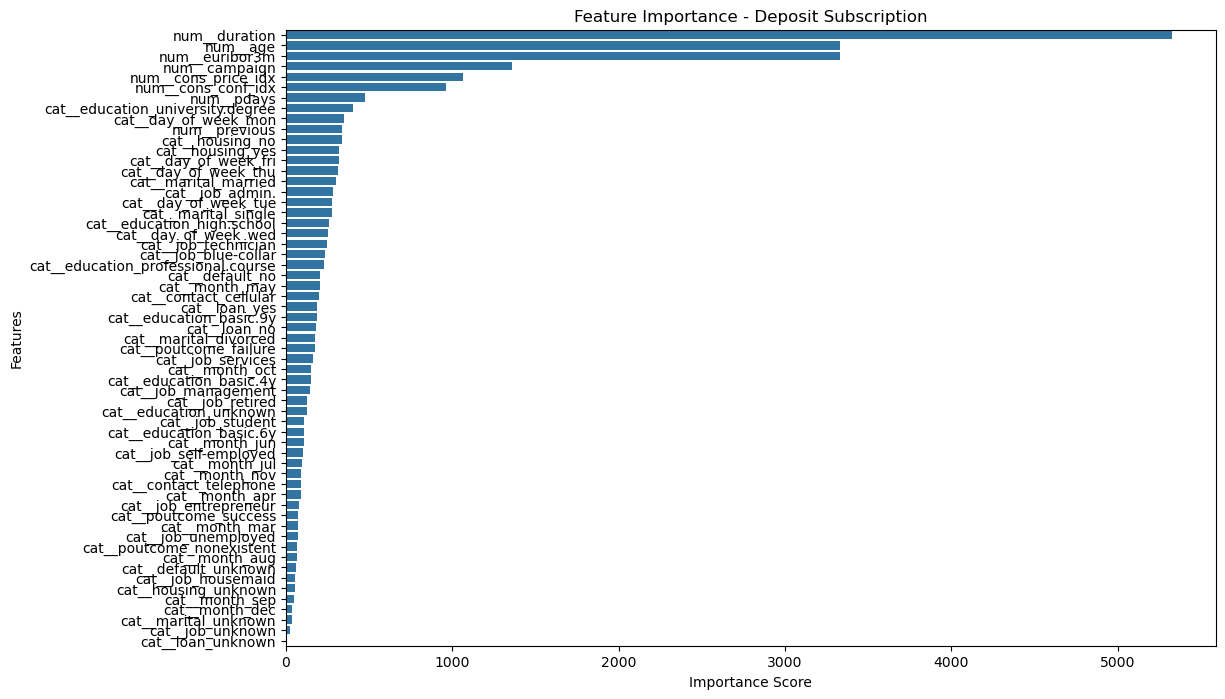

array([3333, 5324, 1361,  476,  340, 1067,  960, 3331,  282,  234,   76,
         56,  144,  128,  105,  162,  109,  250,   70,   26,  175,  303,
        277,   34,  149,  109,  185,  258,  227,  403,  124,  203,   58,
        338,   55,  319,  181,    7,  186,  196,   89,   88,   64,   36,
         96,  107,   70,  203,   92,  152,   51,  318,  350,  316,  280,
        256,  174,   67,   70], dtype=int32)

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract feature names from the preprocessor and importances from the classifier
feature_names = final_model.named_steps['preprocessor'].get_feature_names_out()
importances = final_model.named_steps['classifier'].feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance - Deposit Subscription')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# Interpretation:
# The plot identifies the most influential variables in predicting the target outcome. 
# Features at the top (e.g., duration, social/economic indicators) have the highest predictive power, 
# suggesting they are the primary drivers for the model's classification decisions.

final_model.named_steps['classifier'].feature_importances_

In [50]:
import shap

X_transformed = final_model.named_steps['preprocessor'].transform(X_test)
if hasattr(X_transformed, "toarray"):
    X_transformed = X_transformed.toarray()

explainer = shap.TreeExplainer(final_model.named_steps['classifier'])
shap_values = explainer.shap_values(X_transformed)
shap_values

array([[ 2.05491212e-01, -1.48932326e+00, -5.44715413e-01, ...,
         3.29207429e-02,  8.46445078e-04, -5.59161535e-03],
       [ 6.15630258e-02, -1.15546576e+00,  7.46293516e-01, ...,
         5.56294685e-02,  1.56068781e-02, -1.67258607e-02],
       [ 3.15676529e-02, -9.31847868e-01,  2.27015036e-01, ...,
         6.46712975e-02,  4.71119373e-03, -2.31565376e-02],
       ...,
       [-1.51071737e-02,  3.63353455e+00,  2.16507259e-01, ...,
        -2.92240459e-01, -1.84901732e-02, -2.03920318e-02],
       [ 1.84225146e-01,  7.08812501e+00, -7.73046564e-01, ...,
         2.77776864e-02, -9.05439560e-04, -6.63801004e-03],
       [-1.75782818e-01, -2.00363321e+00, -8.52188501e-01, ...,
         6.08669547e-02,  5.85307551e-03, -1.03494694e-02]])

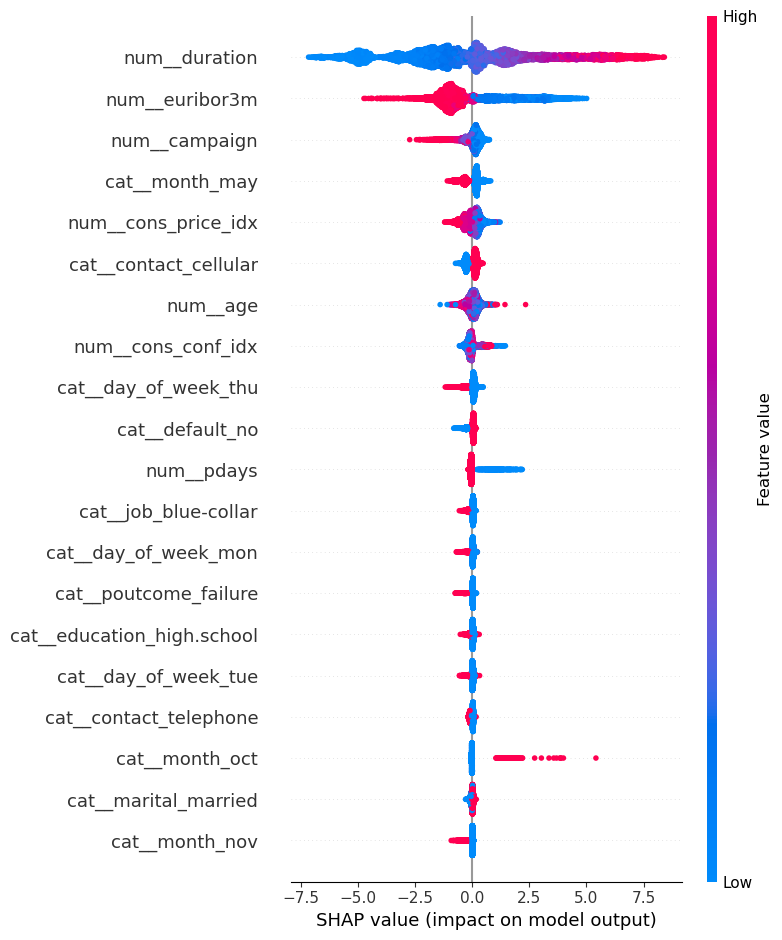

In [51]:
if isinstance(shap_values, list):
    shap_values_to_plot = shap_values[1]
else:
    shap_values_to_plot = shap_values

# summary plot
shap.summary_plot(shap_values_to_plot, X_transformed, feature_names=feature_names)

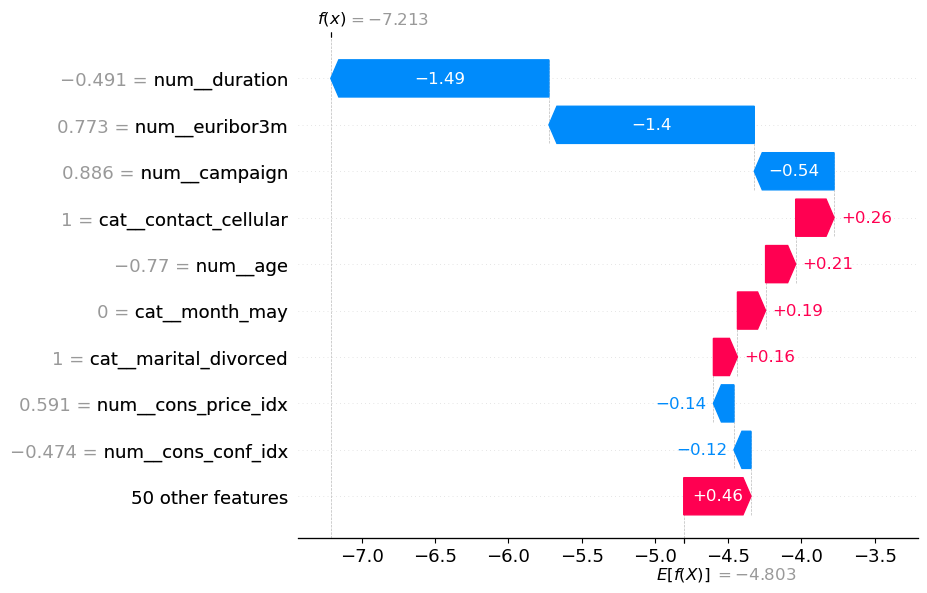

In [52]:
X_df = pd.DataFrame(X_transformed, columns=feature_names)

explanation = explainer(X_df)

if len(explanation.shape) == 3:
    explanation = explanation[:, :, 1]

# single row's shap contribution
shap.plots.waterfall(explanation[0])

Based on the SHAP Beeswarm plot generated above for the **LightGBM** model, we can derive the following key business insights regarding term deposit subscriptions:

#### 1. The "Long-Tail" Conversion Power of Call Duration
* **Observation**: We see a dense cluster of blue dots (short calls) near the zero SHAP value and a sparse, extended "long-tail" of red dots (long calls) stretching far to the right.
* **Insight**: Call duration is the strongest predictor of success. While short calls are the norm and provide a neutral signal, deep engagement (longer duration) acts as a powerful "tipping point" for conversion.
* **Technical Note**: Since `duration` is a *post-event* feature (only known after the call), it reflects high customer interest rather than pre-call intent.

#### 2. Systemic Headwinds from Macroeconomic Indicators
* **Observation**: Macro indicators like `euribor3m` (3-month interest rate) show dense clusters of red dots on the negative (left) side of the SHAP axis.
* **Insight**: High interest rates (and high employment variation) act as systemic headwinds. During these periods, customer appetite for term deposits drops regardless of individual profiles. Marketing efficiency is likely to be lower during these "expensive" economic cycles.

#### 3. Non-Linear Patterns in Demographics (Overlapping Zones)
* **Observation**: Features like `age` show overlapping red and blue dots on both sides of the zero axis.
* **Insight**: The relationship between age and subscription is non-linear. Both younger (blue) and older (red) segments show high propensity, while the middle-aged "cluster" is more resistant. This suggests that marketing strategies should be based on **Life-Stage Personas** rather than simple linear age brackets.

---

In [ ]:
# shap.initjs()
# shap.plots.force(explanation[0:1000])
# shap.plots.heatmap(explanation[0:1000])

## <p style="background-color:#fea162; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">8. Save the Model</p>

<a id="8"></a>


Save the model in folder `/models` for deployment.

In [53]:
import os
import joblib

# Create the model directory if it doesn't exist
os.makedirs('model', exist_ok=True)

# List of models to save
models_to_save = [
    ('xgboost', best_xgb_clf),
    ('lightgbm', best_lgbm_clf),
]

for model_name, model in models_to_save:
    model_path = os.path.join('model', f'{model_name}_model.joblib')
    joblib.dump(model, model_path)
    print(f"Successfully saved {model_name} to {model_path}")

Successfully saved xgboost to model/xgboost_model.joblib
Successfully saved lightgbm to model/lightgbm_model.joblib


In [ ]:
# load the two models

# import joblib
# import os
# best_xgb_clf = joblib.load(os.path.join('model', 'xgboost_model.joblib'))
# best_lgbm_clf = joblib.load(os.path.join('model', 'lightgbm_model.joblib'))

## <p style="background-color:#fea162; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">9. Neural Network Classification (Optional)</p>

<a id="9"></a>

Adding an ANN model just to compare the performance with other models.

In [58]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

dl_preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])  

X_train_transformed = dl_preprocessor.fit_transform(X_train)
X_test_transformed = dl_preprocessor.transform(X_test)

# Define the sequential model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_transformed.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                tf.keras.metrics.AUC(name="roc_auc"),
                tf.keras.metrics.AUC(name="pr_auc", curve="PR"),
                tf.keras.metrics.Precision(name="precision"),
                tf.keras.metrics.Recall(name="recall"),
]
)

# Early stopping
early_stop = EarlyStopping(
    monitor="val_pr_auc",
    mode="max",
    patience=5,
    restore_best_weights=True
)

classes = np.array([0, 1])
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {0: weights[0], 1: weights[1]}
class_weight

{0: np.float64(0.5634790341336616), 1: np.float64(4.438308189655173)}

In [66]:
history = model.fit(
    X_train_transformed, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=256,
    class_weight=class_weight,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6407 - pr_auc: 0.2402 - precision: 0.1998 - recall: 0.4798 - roc_auc: 0.6867 - val_loss: 0.4993 - val_pr_auc: 0.4342 - val_precision: 0.3205 - val_recall: 0.6330 - val_roc_auc: 0.7957
Epoch 2/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5457 - pr_auc: 0.3905 - precision: 0.2776 - recall: 0.6894 - roc_auc: 0.7963 - val_loss: 0.5003 - val_pr_auc: 0.4810 - val_precision: 0.3509 - val_recall: 0.6999 - val_roc_auc: 0.8391
Epoch 3/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 0.5127 - pr_auc: 0.4441 - precision: 0.3157 - recall: 0.7111 - roc_auc: 0.8260 - val_loss: 0.4614 - val_pr_auc: 0.5154 - val_precision: 0.3905 - val_recall: 0.7366 - val_roc_auc: 0.8822
Epoch 4/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4694 - pr_auc: 0.4701 - precision: 0.3424 - recall: 0.7708 - roc_auc: 0.8594 - val_loss: 0.4789 - val_pr_auc: 0.5394 - val_precision: 0.3686 - val_recall: 0.8807 - val_roc_auc: 0.9059
Epoch 5/50
103

In [125]:
y_proba_nn = model.predict(X_test_transformed).ravel()
y_train_proba_nn = model.predict(X_train_transformed).ravel()

# PR curve points (this is for label = 1; if checking label = 0, use predict_proba[:,0] & pos_label=0)
precision, recall, thresholds = precision_recall_curve(y_train, y_train_proba_nn)

# Search for the best threshold (optimized for f1)
best_t_nn, f1 = search_best_threshold(precision, recall, thresholds)
print(best_t_nn)

y_pred_nn = (y_proba_nn >= best_t_nn).astype(int)


258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 0s 168us/step
0.79299


In [126]:
confusion_matrix(y_test, y_pred_nn)
# Still not much of an improvement, and interpretation is not as clear as for the lxgm.

array([[6720,  590],
       [ 193,  735]])

## <p style="background-color:#fea162; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">10. Model w/o Call Duration</p>

<a id="10"></a>

Considering that call duration is mostly a post-hoc variable and in a strictly realistic scenario, it is not possible to know the duration of a call before it takes place.

However, it is the strongest predictor of the target variable. We'll try to remove it from the model and see if the performance degrades significantly.

- Create an XGB model without the duration variable (for speed)

In [ ]:
X_new = X_train.drop('duration', axis=1)

# Calculate scale_pos_weight for imbalance
# scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

small_tree_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), new_n_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

small_xgb_clf = Pipeline([
    ('preprocessor', small_tree_preprocessor),
    ('classifier', XGBClassifier(eval_metric='logloss', random_state=42))
])

# Tuning
print("\nTuning XGBoost...")

rand_small_xgb = GridSearchCV(small_xgb_clf, param_grid=param_xgb, cv=5, scoring='f1', n_jobs=-1)
rand_small_xgb.fit(X_new, y_train)

print(f"Best Params: {rand_small_xgb.best_params_}")
best_small_xgb_clf = rand_small_xgb.best_estimator_

# Best Model Eval
y_pred, small_metrics_xgb = evaluate_cv(best_small_xgb_clf, X_new, y_train)
small_metrics_xgb['Model'] = 'XGBoost'
print(small_metrics_xgb)


Tuning XGBoost...
Best Params: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 7, 'classifier__n_estimators': 200, 'classifier__scale_pos_weight': 7.876616379310345, 'classifier__subsample': 0.8}
Aggregated Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.88      0.91     29238
           1       0.39      0.61      0.48      3712

    accuracy                           0.85     32950
   macro avg       0.67      0.75      0.69     32950
weighted avg       0.88      0.85      0.86     32950

Aggregated Confusion Matrix:
 [[25671  3567]
 [ 1434  2278]]
{'fit_time': array([0.42849588, 0.43224812, 0.46197724, 0.43385506, 0.42124605]), 'score_time': array([0.11033702, 0.10889387, 0.10586691, 0.11078119, 0.1002028 ]), 'test_f1': array([0.5095057 , 0.47052632, 0.46841294, 0.46193416, 0.47480519]), 'test_recall': array([0.63207547, 0.60242588, 0.61455526, 0.60430686, 0.61507402]), '

In [127]:
y_pred_proba = best_small_xgb_clf.predict_proba(X_test.drop(columns='duration'))[:, 1]
y_train_pred_proba = best_small_xgb_clf.predict_proba(X_train.drop(columns='duration'))[:, 1]

precision, recall, thresholds = precision_recall_curve(y_train, y_train_pred_proba)
best_t_no, _ = search_best_threshold(precision, recall, thresholds)
print(best_t)
print(confusion_matrix(y_test, (y_pred_proba >= best_t_no).astype(int)))

0.6446650579336785
[[6949  361]
 [ 494  434]]


It is detrimental to the model if removing the call duration feature. For this classification problem, we need to retain `duration` as a key feature.

In [132]:
# 1. Get the probabilities for the positive class (subscription)
y_proba = best_small_xgb_clf.predict_proba(X_test.drop('duration', axis=1))[:, 1]
 
# 2. Convert probabilities to a 0-100 scale
test_results = pd.DataFrame({
    'Actual': y_test,
    'Probability': y_proba,
    'Lead_Score': (y_proba * 100).astype(int)
})

# 3. Categorize Leads into Tiers
def categorize_lead(score):
    if score > 70: return '1. Hot Lead'
    if score > 40: return '2. Warm Lead'
    return '3. Cold Lead'

test_results['Lead_Tier'] = test_results['Lead_Score'].apply(categorize_lead)

# 4. Analyze the Conversion Rate per Tier
conversion_analysis = test_results.groupby('Lead_Tier').agg({
    'Actual': ['count', 'sum', 'mean']
})
conversion_analysis.columns = ['Total Leads', 'Actual Conversions', 'Conversion Rate']
print(conversion_analysis)

              Total Leads  Actual Conversions  Conversion Rate
Lead_Tier                                                     
1. Hot Lead           923                 476         0.515710
2. Warm Lead         1026                 174         0.169591
3. Cold Lead         6289                 278         0.044204


In [77]:
test_results.head()

,Actual,Probability,Lead_Score,Lead_Tier
14455,0,0.404294,40,3. Cold Lead
36380,0,0.759616,75,1. Hot Lead
40076,0,0.837224,83,1. Hot Lead
10778,0,0.300902,30,3. Cold Lead
27939,0,0.812401,81,1. Hot Lead


In [95]:
test_results["Lead_Tier"] = pd.Categorical(
    test_results["Lead_Tier"],
    categories=["1. Hot Lead", "2. Warm Lead", "3. Cold Lead"],
    ordered=True
)

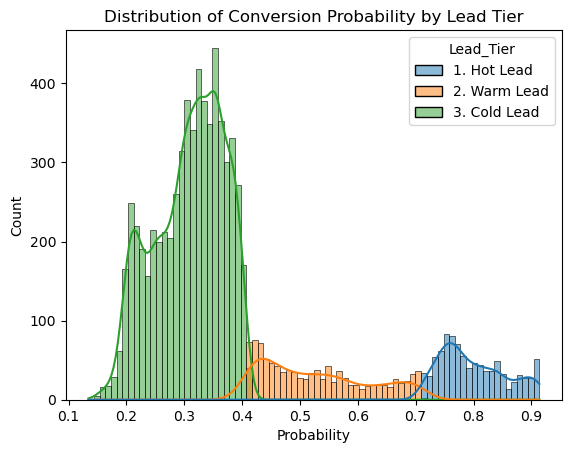

In [96]:
sns.histplot(data=test_results, x='Probability', hue='Lead_Tier', kde=True, bins = 80)
plt.title('Distribution of Conversion Probability by Lead Tier')
plt.show()

- Create an LGBM model without the duration variable (metrics are nearly the same).

In [101]:
small_lgbm_clf = Pipeline([
    ('preprocessor', small_tree_preprocessor),
    ('classifier', LGBMClassifier(random_state=42, verbose=-1, importances_type='gain'))
])

# Tuning - using RandomizedSearchCV
print("\nTuning small LightGBM...")
param_dist_lgbm = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__num_leaves': [31, 50, 100],
    'classifier__max_depth': [-1, 10, 20],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__class_weight': ['balanced', None]
}
rand_small_lgbm = RandomizedSearchCV(small_lgbm_clf, param_distributions=param_dist_lgbm, n_iter=20, cv=5, scoring='f1', n_jobs=-1, random_state=42)
rand_small_lgbm.fit(X_new, y_train)

print(f"Best Params: {rand_small_lgbm.best_params_}")
best_small_lgbm_clf = rand_small_lgbm.best_estimator_

# Best Model Eval
y_pred,small_metrics_lgbm = evaluate_cv(best_small_lgbm_clf, X_new, y_train)
small_metrics_lgbm['Model'] = 'LightGBM'
small_metrics_lgbm


Tuning small LightGBM...


/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted w

Best Params: {'classifier__subsample': 0.8, 'classifier__num_leaves': 100, 'classifier__n_estimators': 100, 'classifier__max_depth': -1, 'classifier__learning_rate': 0.05, 'classifier__colsample_bytree': 1.0, 'classifier__class_weight': 'balanced'}


/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted w

Aggregated Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.88      0.91     29238
           1       0.39      0.62      0.48      3712

    accuracy                           0.85     32950
   macro avg       0.67      0.75      0.69     32950
weighted avg       0.88      0.85      0.86     32950

Aggregated Confusion Matrix:
 [[25664  3574]
 [ 1423  2289]]


/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted w

{'fit_time': array([9.08063483, 9.05557609, 9.10216117, 9.14787602, 9.15269709]),
 'score_time': array([0.07161689, 0.08326077, 0.063061  , 0.07076573, 0.06595516]),
 'test_f1': array([0.50918919, 0.47816826, 0.47433265, 0.46375321, 0.4667349 ]),
 'test_recall': array([0.63477089, 0.60512129, 0.62264151, 0.60699865, 0.61372813]),
 'test_precision': array([0.42509025, 0.39524648, 0.38308458, 0.37520799, 0.37654831]),
 'test_f1_macro': array([0.71452399, 0.69572897, 0.69158228, 0.68545916, 0.68695733]),
 'test_balanced_accuracy': array([0.76292238, 0.74382262, 0.74770926, 0.73927836, 0.74230104]),
 'test_roc_auc': array([0.81404279, 0.78718183, 0.78997854, 0.78120896, 0.78651301]),
 'Model': 'LightGBM'}

In [133]:
y_pred_proba = best_small_lgbm_clf.predict_proba(X_test.drop(columns='duration'))[:, 1]
y_train_pred_proba = best_small_lgbm_clf.predict_proba(X_train.drop(columns='duration'))[:, 1]

precision, recall, thresholds = precision_recall_curve(y_train, y_train_pred_proba)
best_t_no, _ = search_best_threshold(precision, recall, thresholds)

print(best_t_no)
print(confusion_matrix(y_test, (y_pred_proba >= best_t_no).astype(int)))


0.7431057967299506
[[6847  463]
 [ 446  482]]


<a id="11"></a>

## <p style="background-color:#fea162; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">11. Conclusion</p>

We developed a predictive framework to optimize the Portuguese bank's telemarketing efforts for term deposit subscriptions. The main challenge in the dataset is the imbalanced class distribution and the presence of "duration" as a "leaking" variable (i.e., a feature that is highly predictive but practically unuseful for pre-call planning).

We used a two-stage modeling approach:

- **Diagnostic Model:** Included all features (excluding highly correlated ones) to obtain:

    - Features like call duration and economic indicators (like euribor3m) were the primary historical drivers of success.
    - Ensembel models (XGBoost, LightGBM) showed strongest overall performance (macro-F1). Optimized with a tuned threshold based on the full training dataset.

- **Predictive "Pre-Call" Model:** Utilized a XGB/LightGBM classifier—optimized with a tuned threshold to rank leads without using post-hoc information. This model achieved high utility by focusing on the Precision-Recall tradeoff, ensuring that the bank’s limited human resources are spent on the leads most likely to convert.

### Model Strategy and Optimization

The transition from a "Cold Calling" approach to a Sales Intelligence model provides the bank with a high-efficiency roadmap for future campaigns. By implementing the Decile-based Lead Scoring System, the business can move away from binary predictions and toward a value-based outreach strategy.

#### 1. Efficiency Gains through Tiering
The model demonstrates that by focusing on Tier 1 (High Priority) leads, the bank can capture over 50% of all potential subscribers while reducing total call volume by 80%. This represents a massive increase in operational ROI. E.g.,

- Tier 1 (High Priority): 5x more likely to convert than a random lead; designated for senior sales agents.
- Tier 2 (Medium Priority): Conversion rates at or slightly above the 11% baseline; designated for standard outreach.
- Tier 3 (Digital Nurture): Bottom 60+% of leads; these can be removed from the calling queue and handled via low-cost automated email/SMS.

#### 2. Tactical Recommendations

**Optimized Timing:** The heavy influence of `euribor3m` and `num_campaign`, `pdays` suggests that the when is as important as the who. Campaigns should be triggered by specific economic windows and the recency of client interaction.